In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
from plotnine import ggplot, geom_line, facet_wrap, aes, scale_fill_gradient2, theme, labs, geom_point, scale_color_manual, \
geom_text, scale_fill_gradient2, theme_minimal, geom_boxplot, geom_tile, scale_x_discrete,element_text,scale_y_discrete
from pandas.api.types import CategoricalDtype

from ydata_profiling import ProfileReport

In [2]:
pd.set_option('display.max_rows', 100)
target_columns = [
    'Timestamp','Temperature', 'Precipitation_log', 'Humidity', 'Wind_Speed_kmh',
    'Soil_Moisture', 'Soil_Temperature', 'Wind_Dir_Sin', 'Wind_Dir_Cos'
]
df = pd.read_csv('data/cleaned_data.csv')[target_columns]

# resample em hora e interpola para ter frequência fixa
df.head()

,Timestamp,Temperature,Precipitation_log,Humidity,Wind_Speed_kmh,Soil_Moisture,Soil_Temperature,Wind_Dir_Sin,Wind_Dir_Cos
0,2024-05-30 00:00:00,9.542,0.0,67.483,0.755,8312.000,9.430,0.216440,-0.976296
1,2024-05-30 00:30:00,7.381,0.0,74.983,0.708,8290.667,6.465,0.846500,-0.532389
2,2024-05-30 01:00:00,6.224,0.0,79.450,0.765,8301.333,6.237,0.482258,-0.876029
3,2024-05-30 01:30:00,5.308,0.0,85.167,0.498,8304.000,6.017,0.681998,-0.731354
4,2024-05-30 02:00:00,5.218,0.0,86.517,0.125,8298.667,6.353,0.673438,-0.739243


In [ ]:
profile = ProfileReport(df, title='Profile Report')
profile.to_file('profile_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 9/9 [00:00<00:00, 52.94it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Season'] = df['Timestamp'].apply(get_season)
df.head()

,Timestamp,Temperature,Precipitation_log,Humidity,Wind_Speed_kmh,Soil_Moisture,Soil_Temperature,Wind_Dir_Sin,Wind_Dir_Cos,Season,Hour,DayNight,TimestampVancouver,HourVancouver,DayNightVancouver
0,2024-05-30 00:00:00+00:00,9.542,0.0,67.483,0.755,8312.000,9.430,0.216440,-0.976296,Spring,0,Night,2024-05-30 12:00:00+12:00,12,Day
1,2024-05-30 00:30:00+00:00,7.381,0.0,74.983,0.708,8290.667,6.465,0.846500,-0.532389,Spring,0,Night,2024-05-30 12:30:00+12:00,12,Day
2,2024-05-30 01:00:00+00:00,6.224,0.0,79.450,0.765,8301.333,6.237,0.482258,-0.876029,Spring,1,Night,2024-05-30 13:00:00+12:00,13,Day
3,2024-05-30 01:30:00+00:00,5.308,0.0,85.167,0.498,8304.000,6.017,0.681998,-0.731354,Spring,1,Night,2024-05-30 13:30:00+12:00,13,Day
4,2024-05-30 02:00:00+00:00,5.218,0.0,86.517,0.125,8298.667,6.353,0.673438,-0.739243,Spring,2,Night,2024-05-30 14:00:00+12:00,14,Day


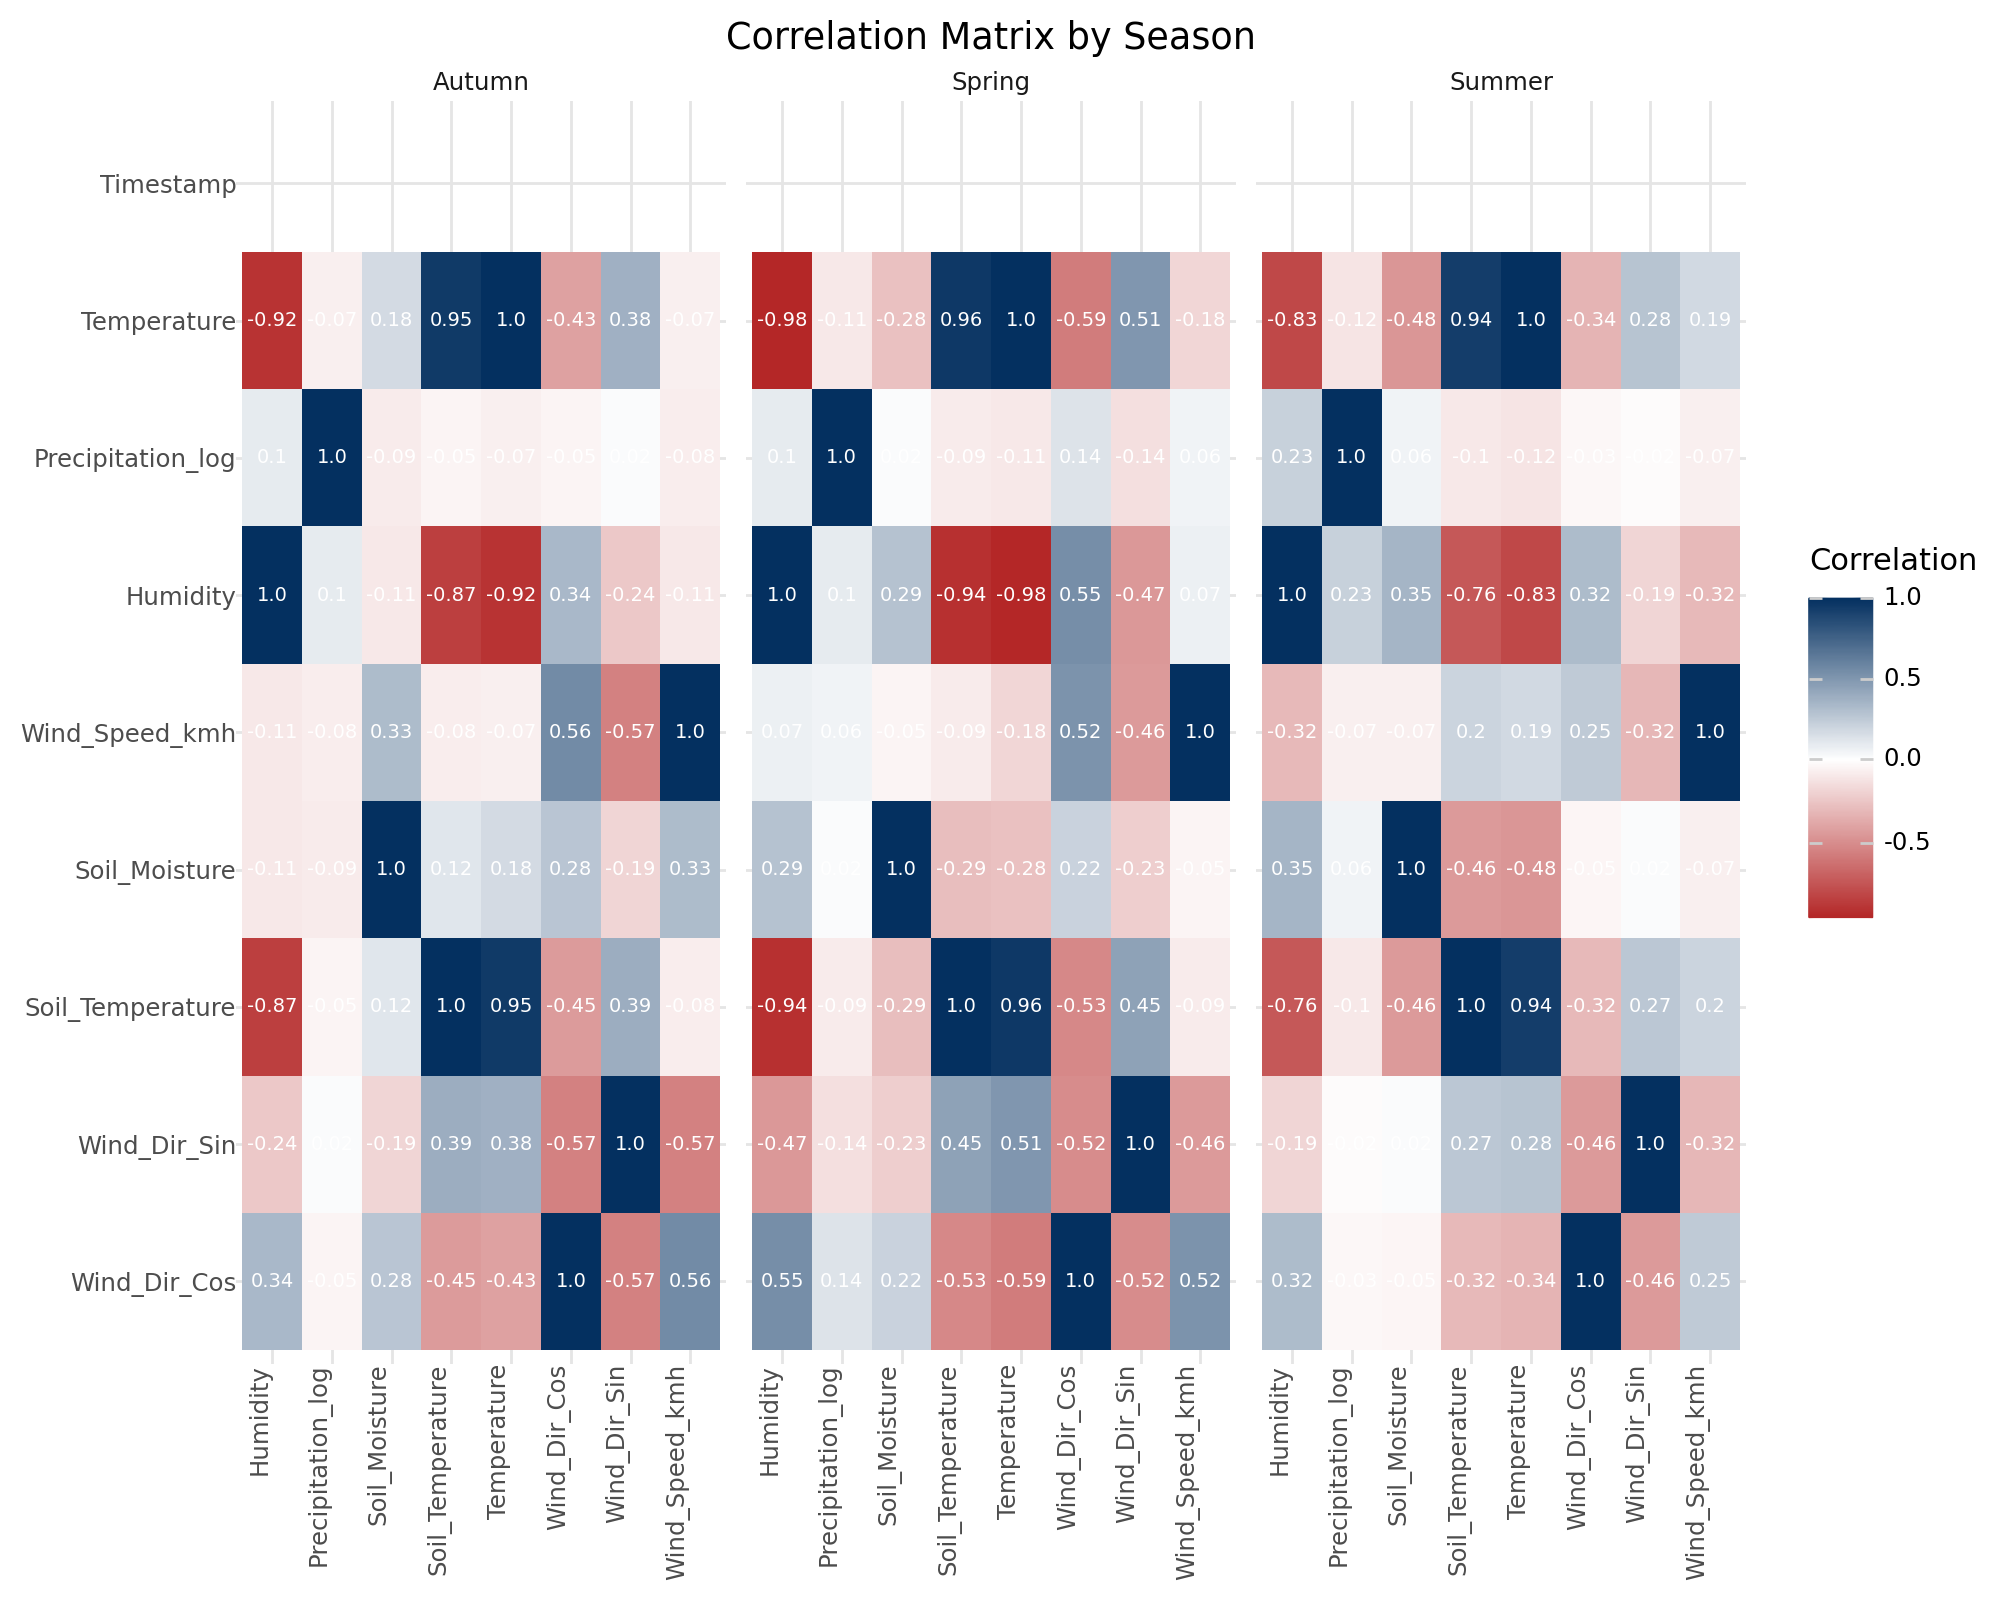

In [4]:
# Create an empty list to store long-form correlation data per season
season_corrs = []

# Loop through each season to calculate correlations
for season, group in df.groupby('Season'):
    numeric_group = group.select_dtypes(include='number')
    corr = numeric_group.corr().reset_index().melt(id_vars='index')
    corr.columns = ['Variable1', 'Variable2', 'Correlation']
    corr['Season'] = season
    season_corrs.append(corr)

# Combine all into a single DataFrame
corr_long = pd.concat(season_corrs)


# Plot with facet for each season
plot = (
    ggplot(corr_long, aes(x='Variable1', y='Variable2', fill='Correlation')) +
    geom_tile() +
    geom_text(aes(label='round(Correlation, 2)'), color='white', size=7) +
    scale_fill_gradient2(low='firebrick', mid='white', high='#043060', midpoint=0) +
    scale_y_discrete(limits=target_columns[::-1]) +
    theme_minimal() +
    theme(
        figure_size=[10,8],
        axis_text_x=element_text(rotation=90, ha='right', va='top')
    ) +
    facet_wrap('~Season') +
    labs(title='Correlation Matrix by Season', x='', y='')
)

plot.show()

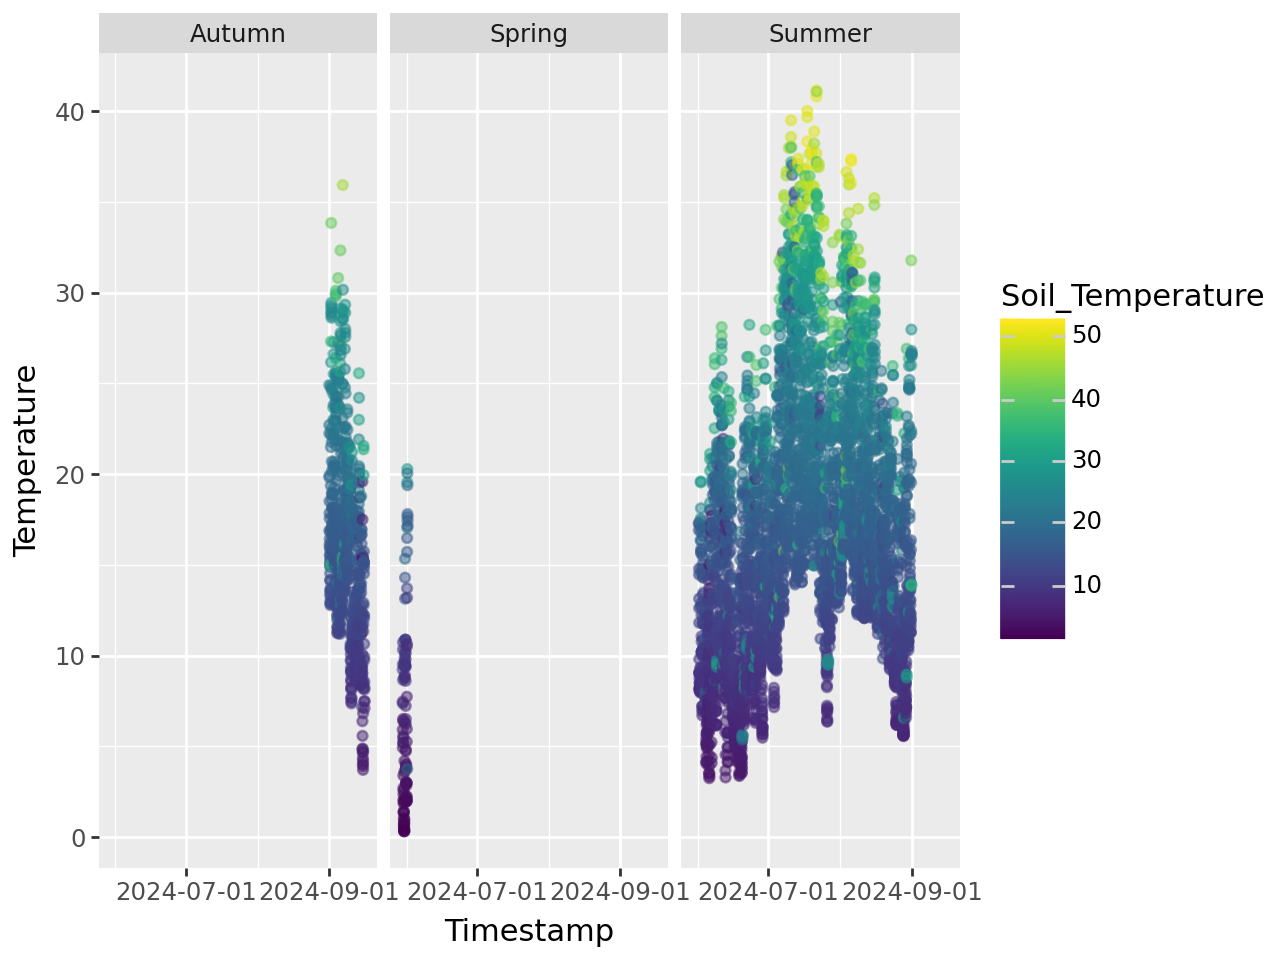

In [ ]:
# verificar temperatura
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Temperature', color='Soil_Temperature'), alpha=0.5)
    + facet_wrap('~Season')
)
p.show()

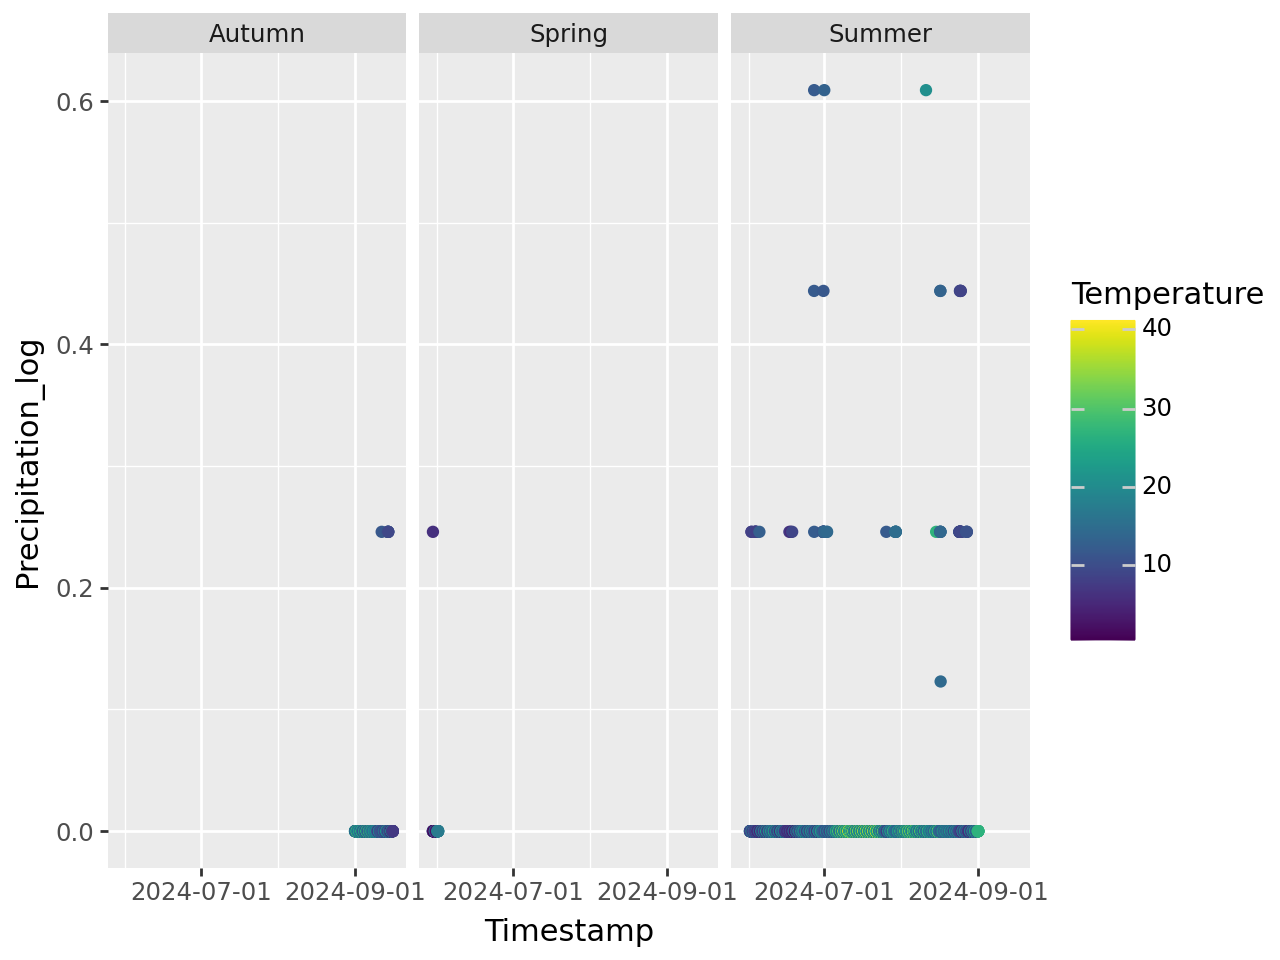

In [ ]:
# verificar correlação temperatura e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation_log', color='Temperature'))
    + facet_wrap('~Season')
)
p.show()

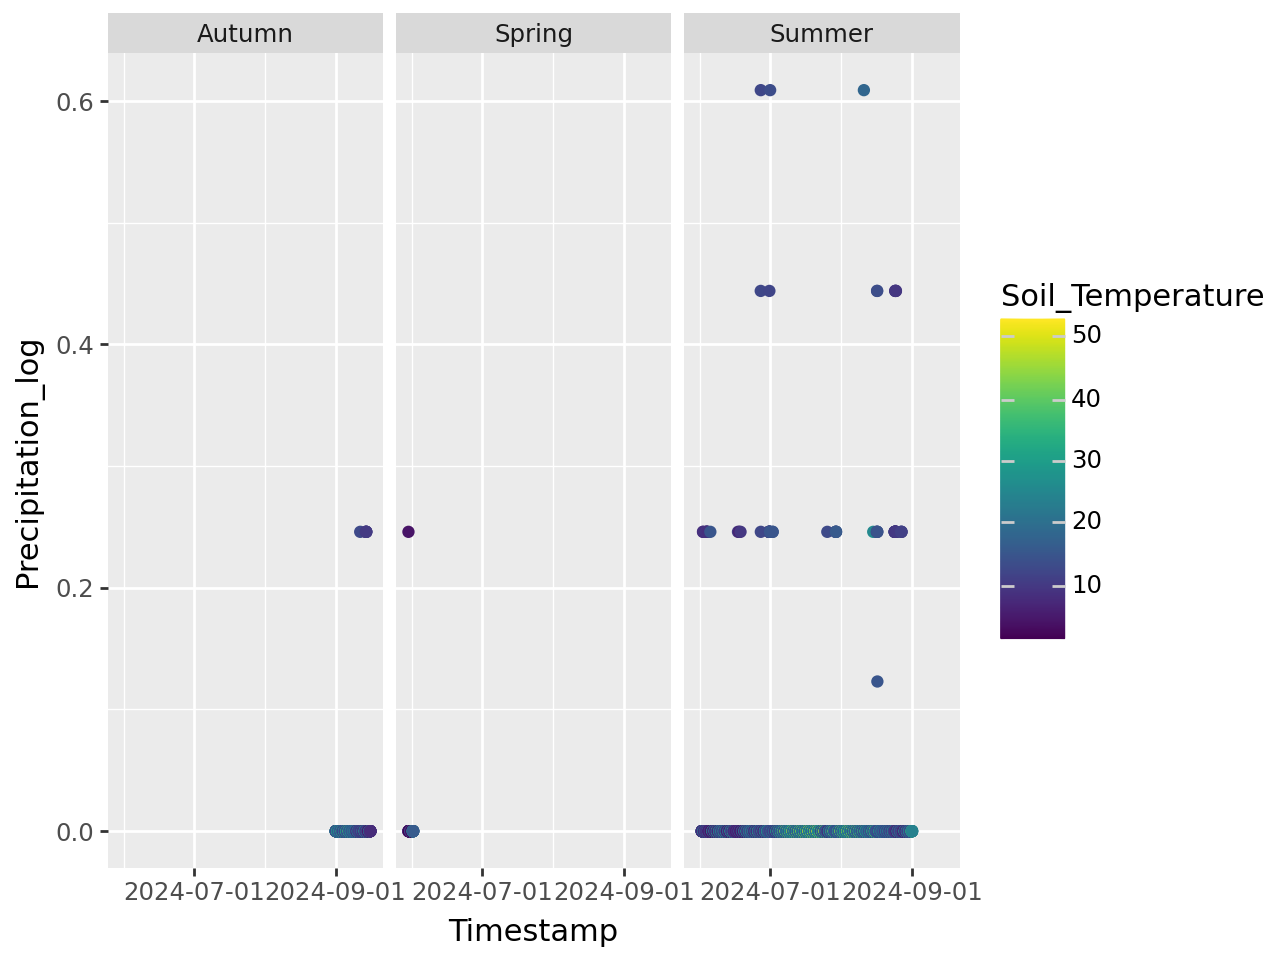

In [ ]:
# verificar correlação temperatura do solo e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation_log', color='Soil_Temperature'))
    + facet_wrap('~Season')
)
p.show()

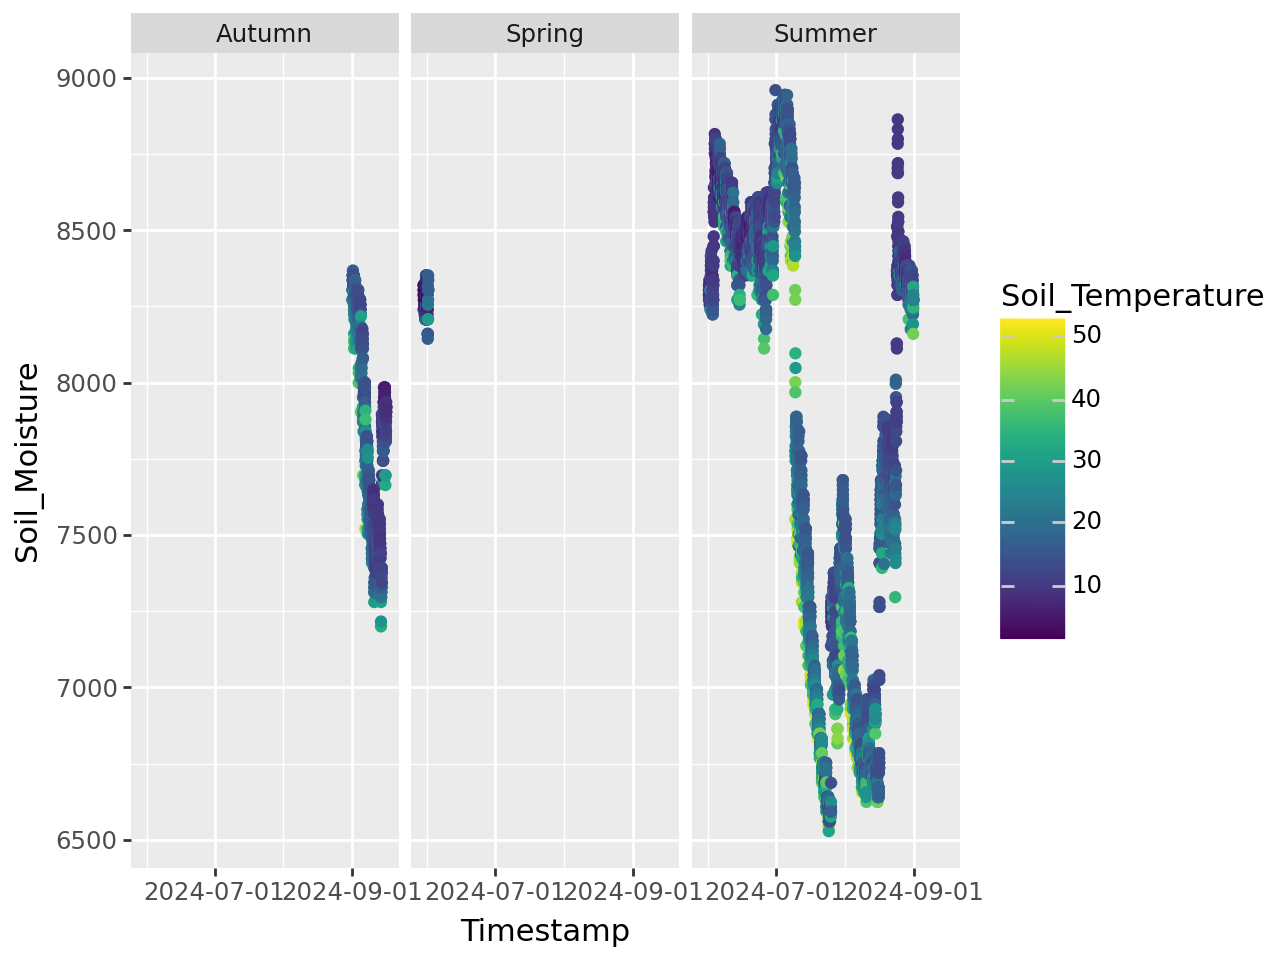

In [ ]:
# verificar correlação umidade do solo e temperatura do solo
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Soil_Moisture', color='Soil_Temperature'))
    + facet_wrap('~Season')
)
p.show()

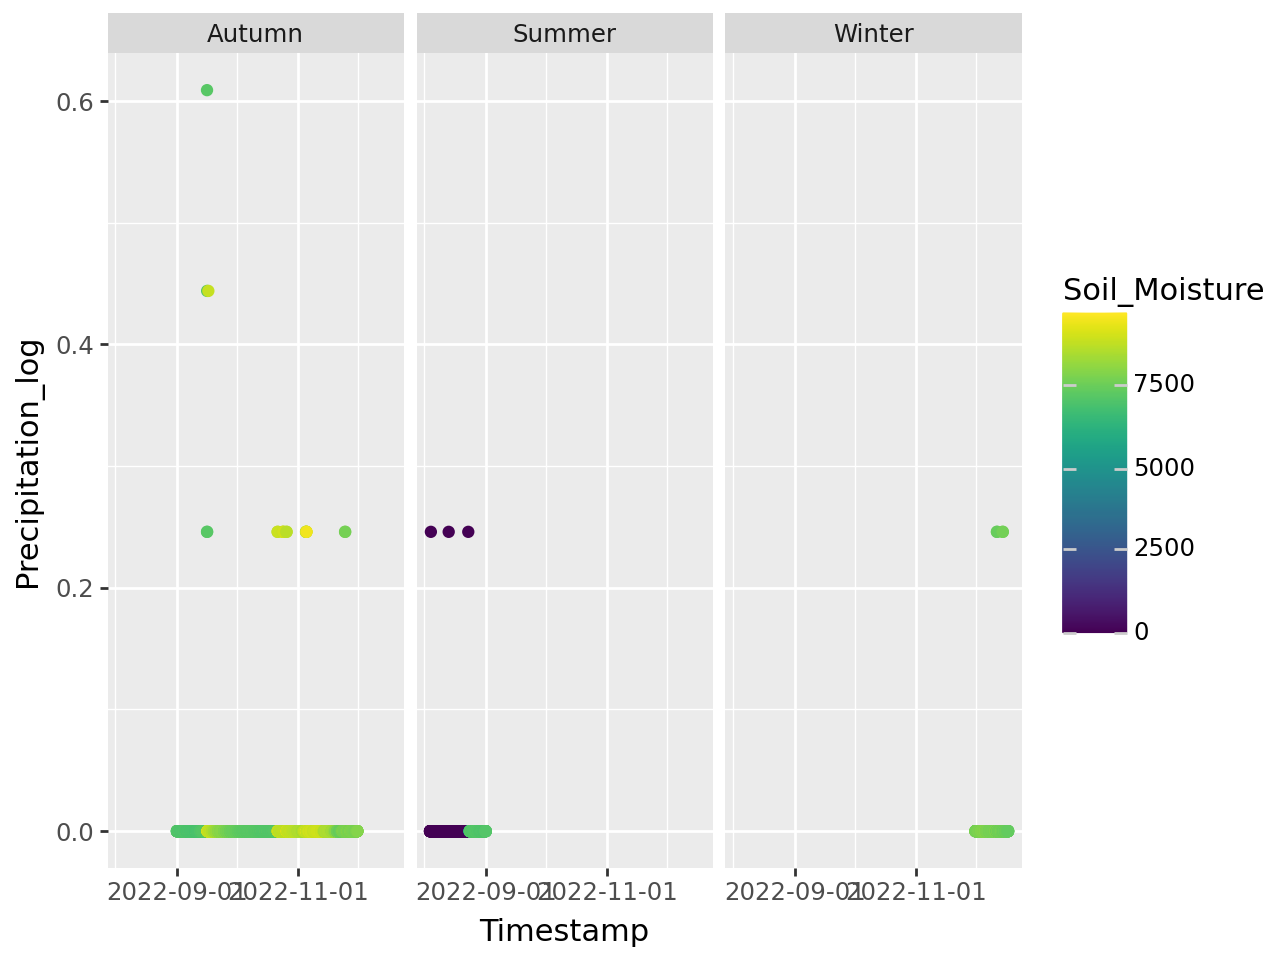

In [ ]:
# verificar correlação umidade do solo e precipitação
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Precipitation_log', color='Soil_Moisture'))
    + facet_wrap('~Season')
)
p.show()

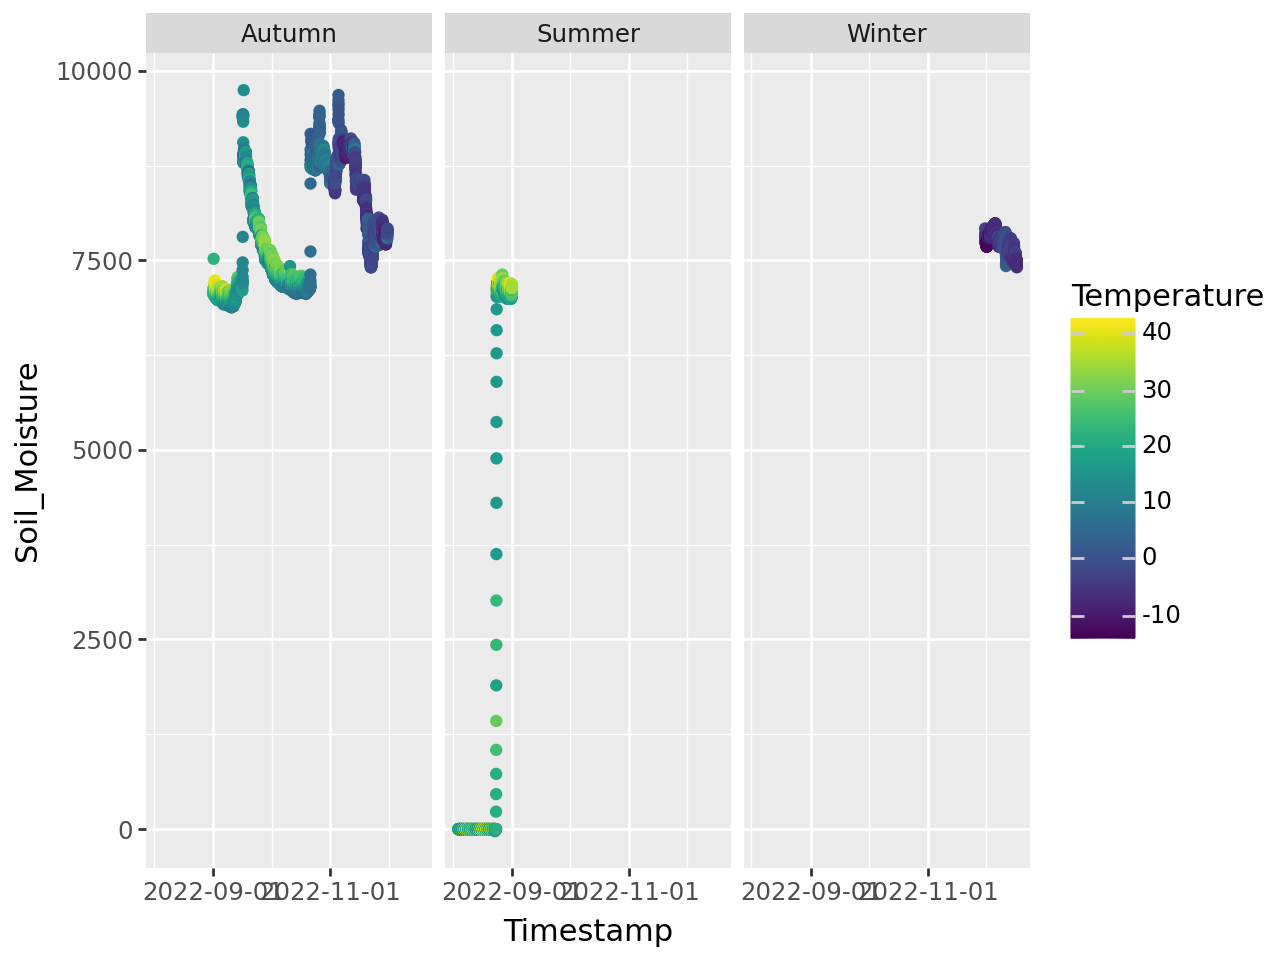

In [ ]:
# verificar correlação umidade do solo e temperatura
p = (
    ggplot(df)
    + geom_point(aes(x='Timestamp', y='Soil_Moisture', color='Temperature'))
    + facet_wrap('~Season')
)
p.show()

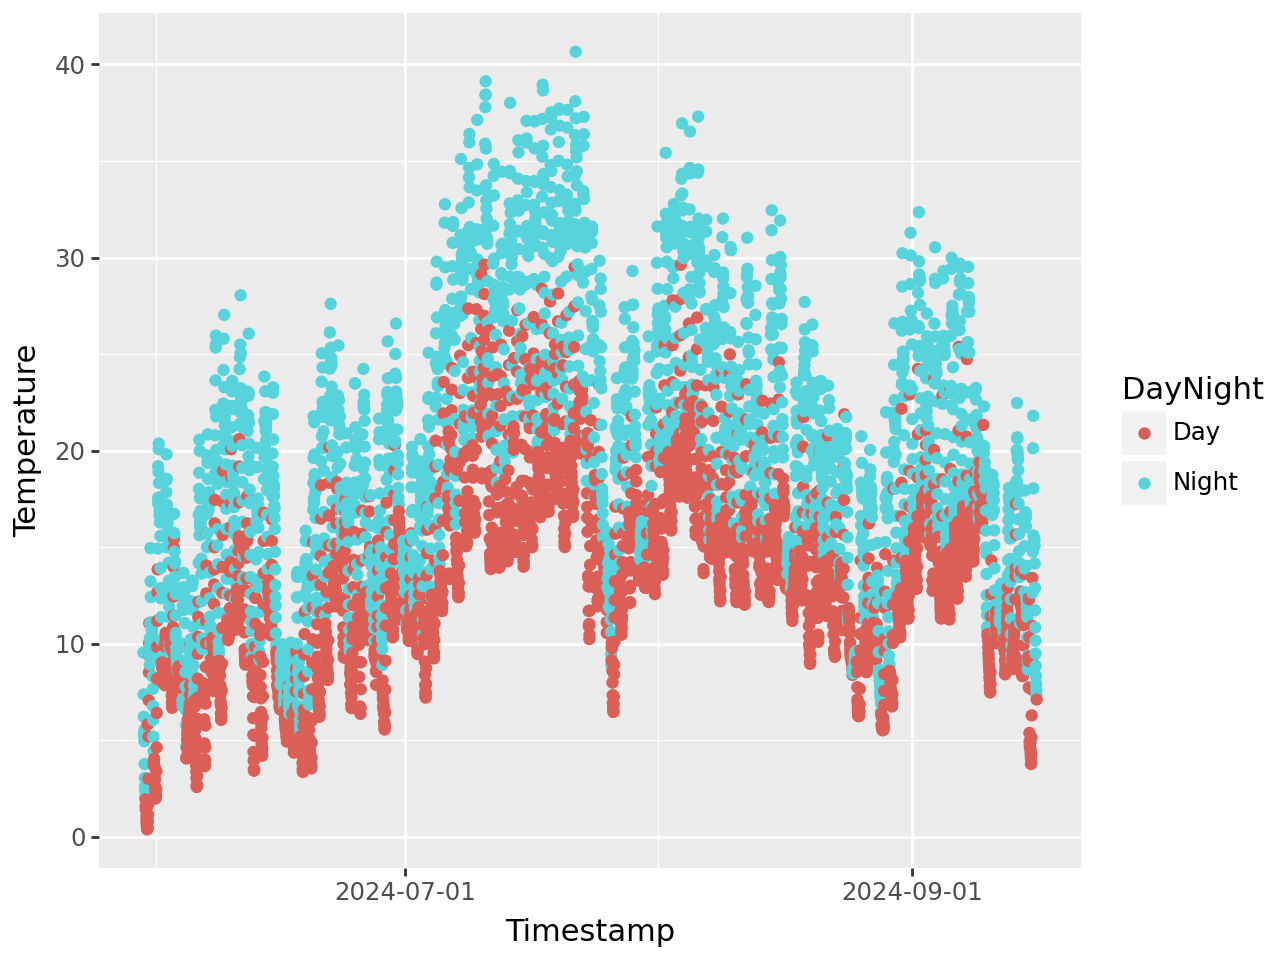

In [11]:
# definir as estações do ano
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Season'] = df['Timestamp'].apply(get_season)

# define se a hora é de dia ou de noite 6h até as 18h é considerado dia o resto é noite
df['Hour'] = df['Timestamp'].dt.hour
df['DayNight'] = df['Hour'].apply(lambda h: 'Day' if 6 <= h < 18 else 'Night')

# verificar temperatura do solo vs temperatura normal de noite e de dia
p = (
    ggplot(df)
    + geom_point(aes(x="Timestamp", y="Temperature", color='DayNight'))
)
p.show()

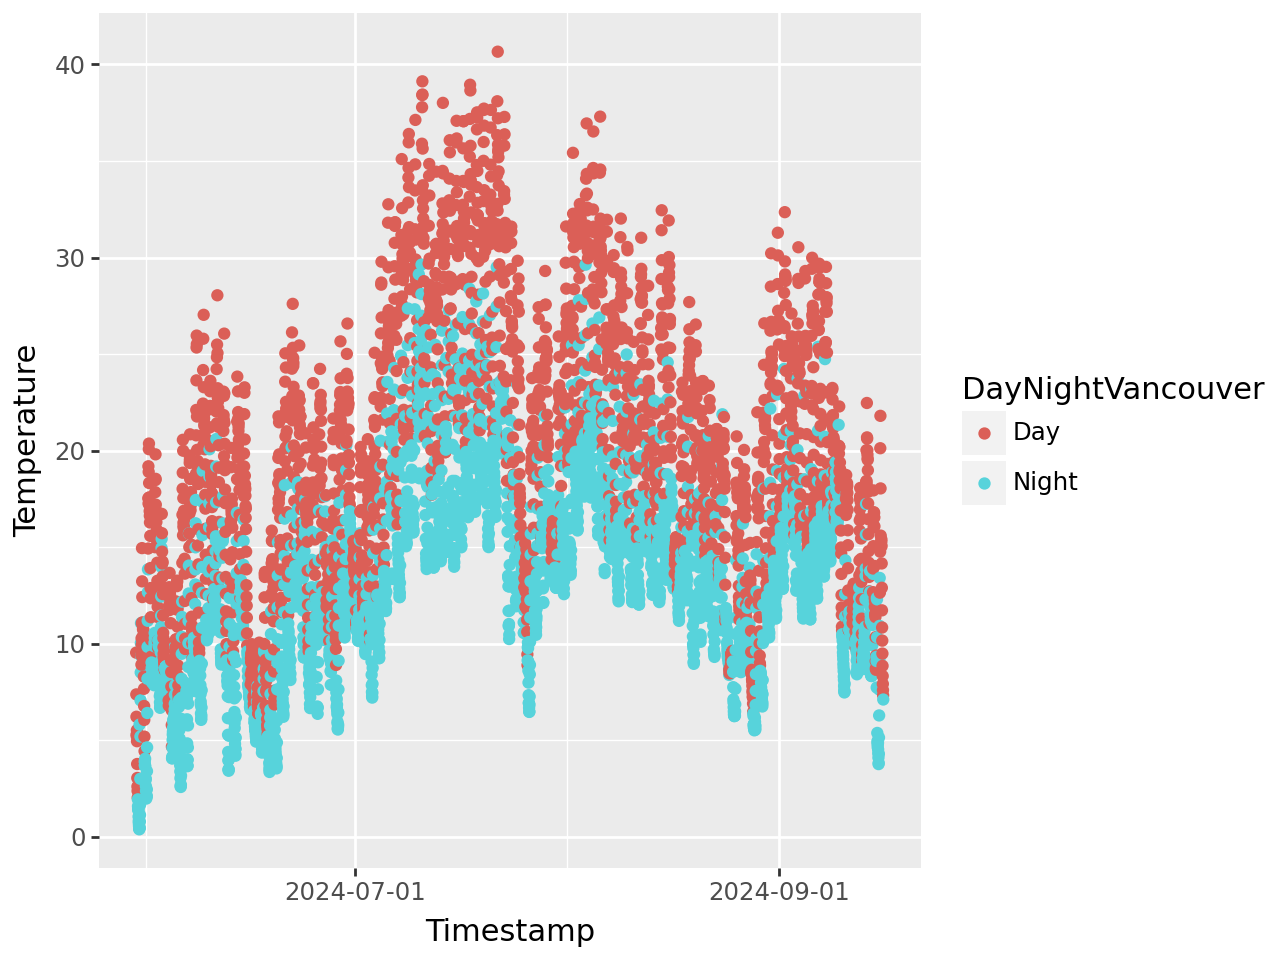

In [6]:
# para testar se os dados estão com outra zona temporal
df['Timestamp'] = pd.to_datetime(df['Timestamp'], utc=True)
df['TimestampVancouver'] = df['Timestamp'].dt.tz_convert('Pacific/Auckland')

df['HourVancouver'] = df['TimestampVancouver'].dt.hour
df['DayNightVancouver'] = df['HourVancouver'].apply(lambda h: 'Day' if 6 <= h < 18 else 'Night')

# verificando se a diferença é por causa da timezone
p = (
    ggplot(df)
    + geom_point(aes(x="Timestamp", y="Temperature", color='DayNightVancouver'))
)
p.show()

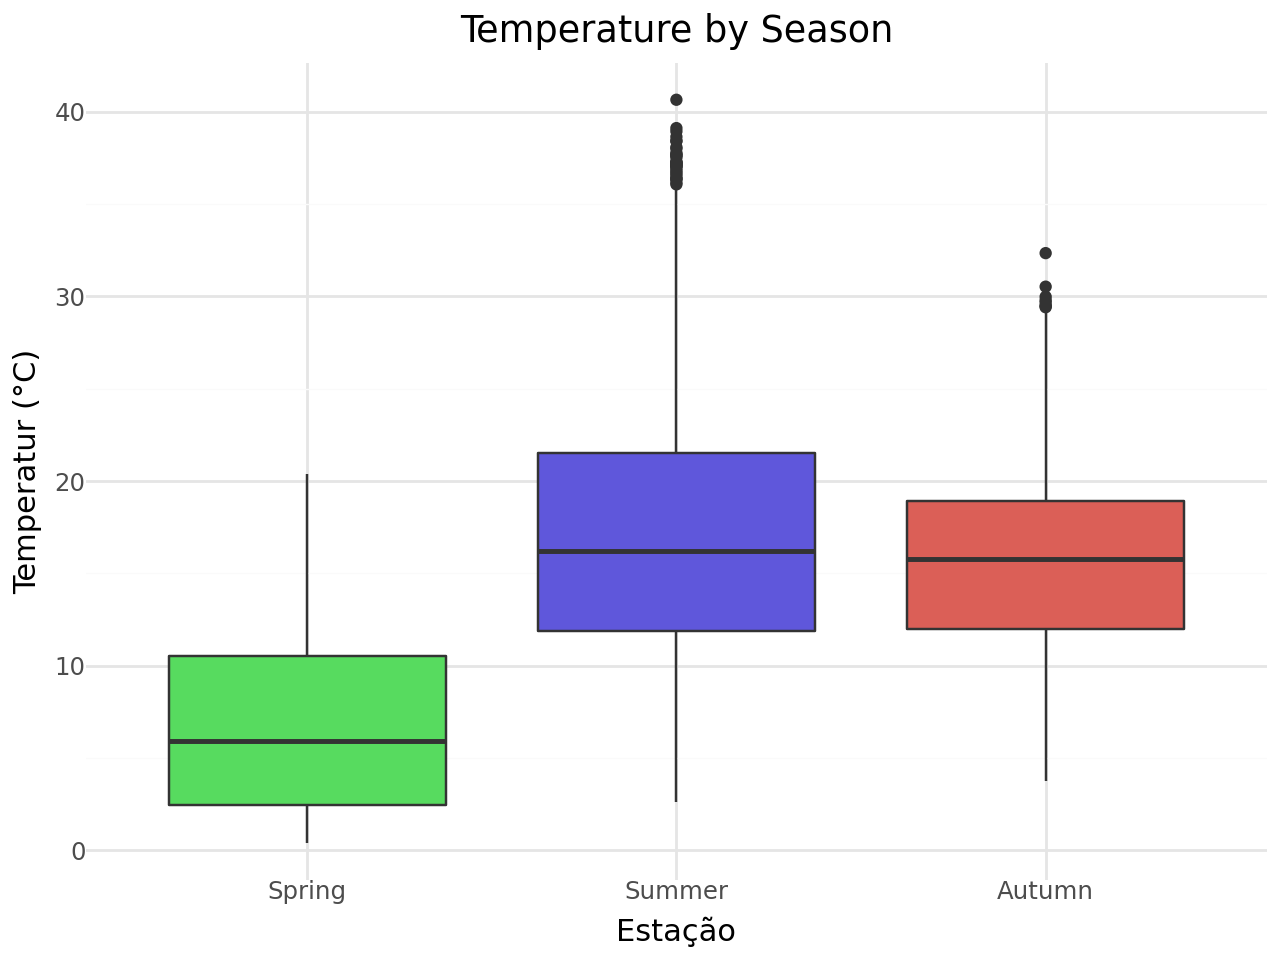

In [7]:
season_order = df['Season'].astype(str).drop_duplicates().tolist()

plot = (
    ggplot(df, aes(x='Season', y='Temperature', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Temperature by Season',
        x='Estação',
        y='Temperatur (°C)'
    )
)
plot.show()

In [ ]:
plot = (
    ggplot(df, aes(x='Season', y='Precipitation', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Precipitation by Season',
        x='Estação',
        y='Precipitação (mm)'
    )
)
plot.show()

PlotnineError: "Could not evaluate the 'y' mapping: 'Precipitation' (original error: name 'Precipitation' is not defined)"

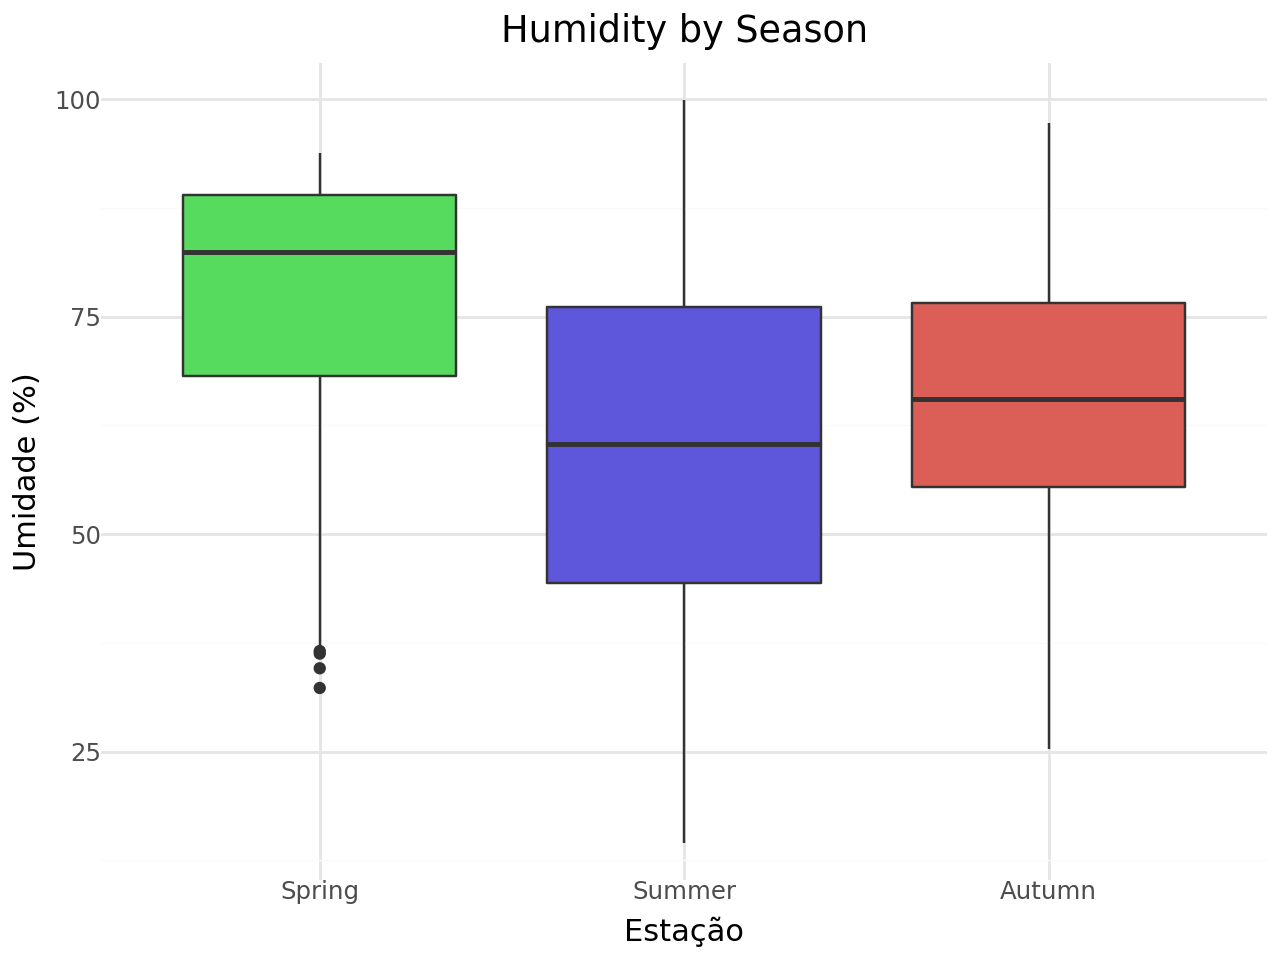

In [8]:
plot = (
    ggplot(df, aes(x='Season', y='Humidity', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Humidity by Season',
        x='Estação',
        y='Umidade (%)'
    )
)
plot.show()

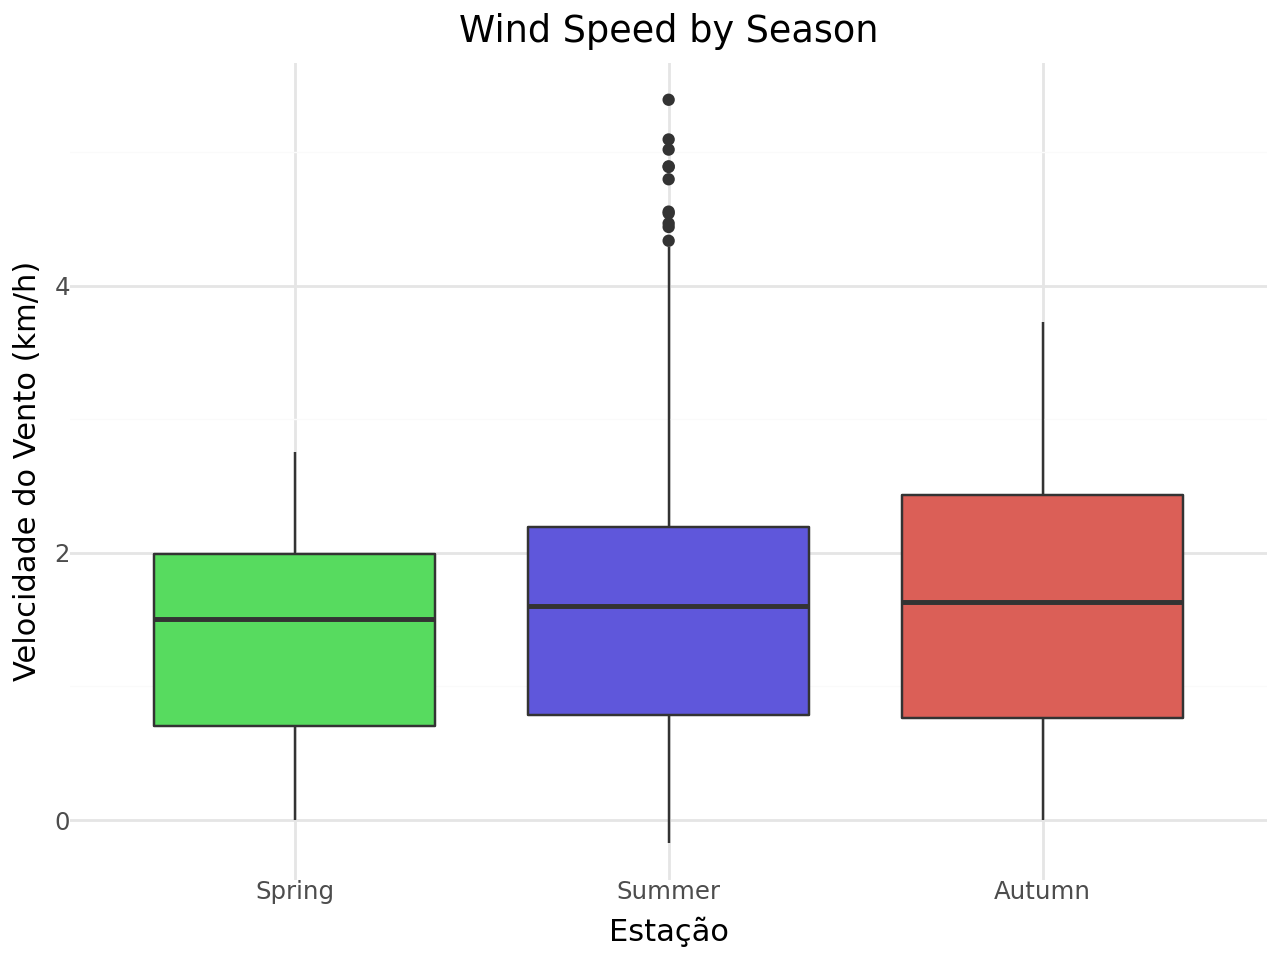

In [9]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Speed_kmh', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Speed by Season',
        x='Estação',
        y='Velocidade do Vento (km/h)'
    )
)
plot.show()

In [ ]:
plot = (
    ggplot(df, aes(x='Season', y='Wind_Direction', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Wind Direction by Season',
        x='Estação',
        y='Direção do Vento (graus)'
    )
)
plot.show()

PlotnineError: "Could not evaluate the 'y' mapping: 'Wind_Direction' (original error: name 'Wind_Direction' is not defined)"

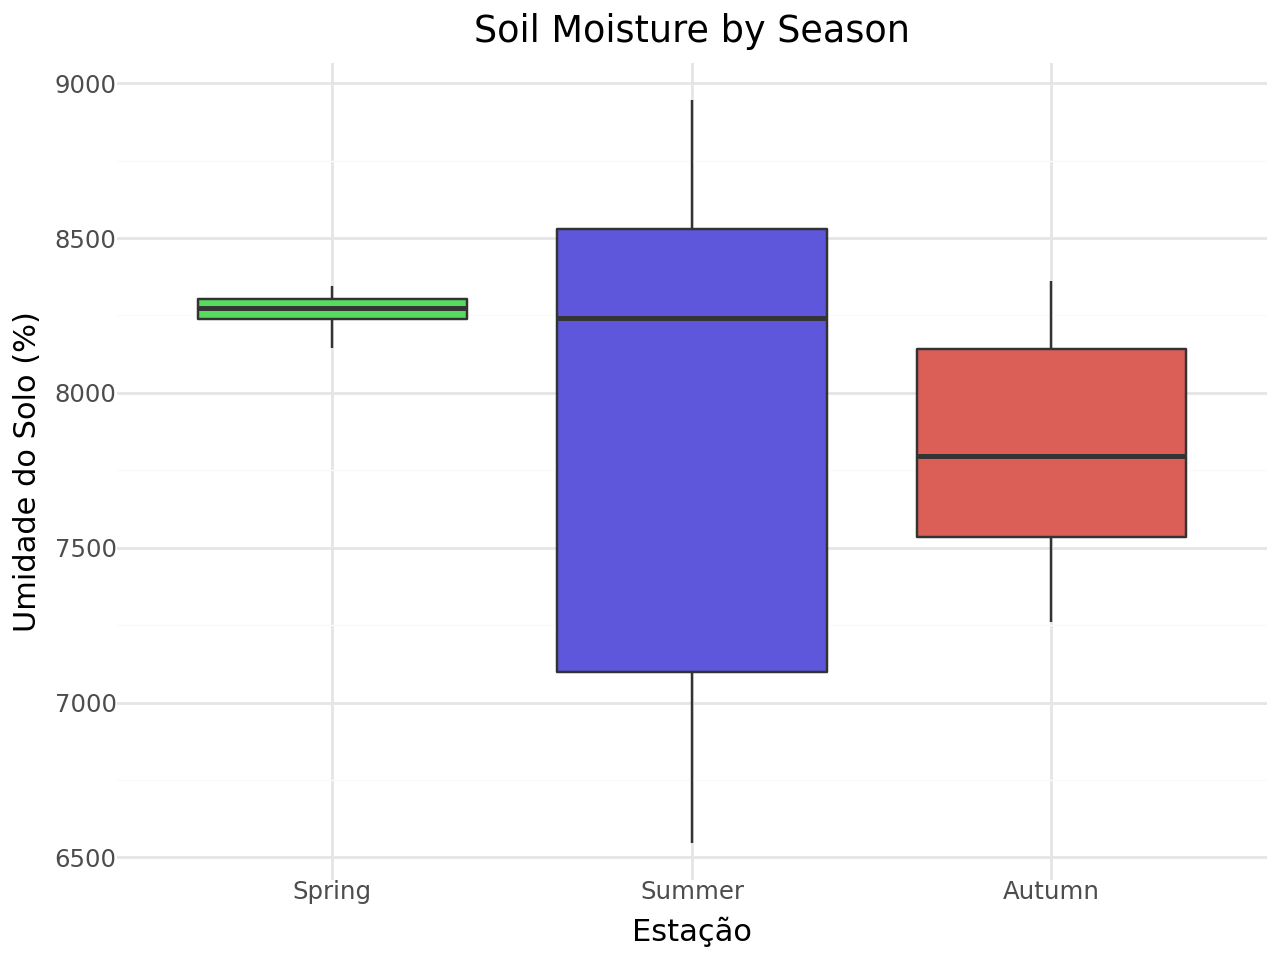

In [15]:
plot = (
    ggplot(df, aes(x='Season', y='Soil_Moisture', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Soil Moisture by Season',
        x='Estação',
        y='Umidade do Solo (%)'
    )
)
plot.show()

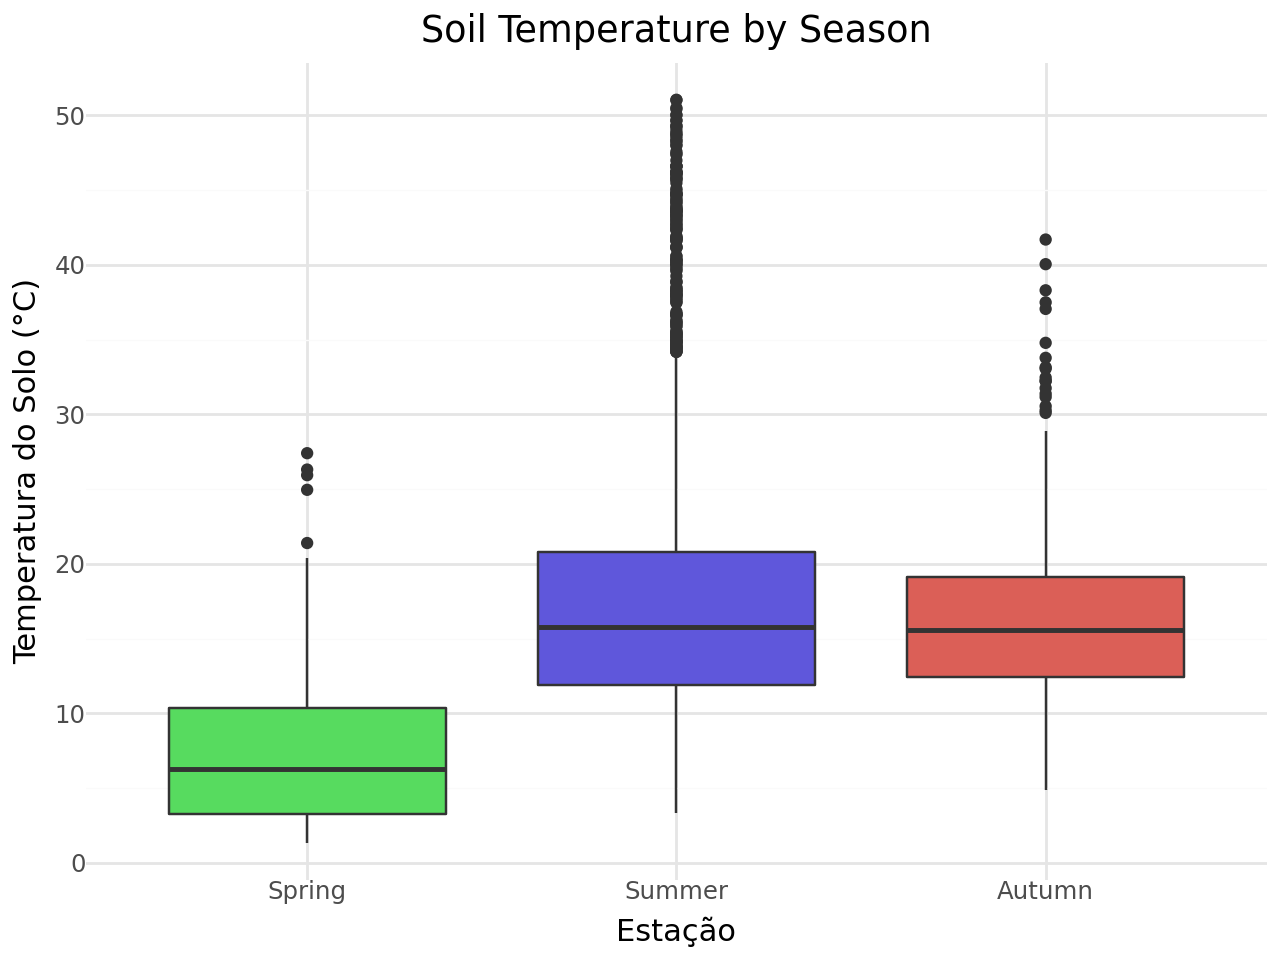

In [14]:
plot = (
    ggplot(df, aes(x='Season', y='Soil_Temperature', fill='Season'))
    + geom_boxplot(show_legend=False)
    + scale_x_discrete(limits=season_order)  # aqui
    + theme_minimal()
    + labs(
        title='Soil Temperature by Season',
        x='Estação',
        y='Temperatura do Solo (°C)'
    )
)
plot.show()